In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

sns.set_style('whitegrid')

In [3]:
# funzione che prepara i dati per il modello
def prepare_data(df, target_col, drop_cols=[],
                dummies_cols=[], labels_cols=[],
                standardize_cols=[], log_standardize_cols=[],
                minmax_standardize_cols=[], seed=42):
    X = df.drop(columns=[target_col] + drop_cols, axis=1)
    y = df[target_col]

    if dummies_cols:
        X = pd.get_dummies(X, columns=dummies_cols)

    if labels_cols:
        encoder = LabelEncoder()
        for col in labels_cols:
            X[col] = encoder.fit_transform(X[col])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed)

    if standardize_cols:
        scaler = StandardScaler()
        X_train[standardize_cols] = np.round(scaler.fit_transform(X_train[standardize_cols]), 2)
        X_test[standardize_cols] = np.round(scaler.transform(X_test[standardize_cols]), 2)

    if log_standardize_cols:
        scaler = StandardScaler()
        X_train[log_standardize_cols] = np.round(scaler.fit_transform(np.log(X_train[log_standardize_cols] + 1)), 2)
        X_test[log_standardize_cols] = np.round(scaler.transform(np.log(X_test[log_standardize_cols] + 1)), 2)
    
    if minmax_standardize_cols:
        scaler = MinMaxScaler()
        X_train[minmax_standardize_cols] = np.round(scaler.fit_transform(X_train[minmax_standardize_cols]), 2)
        X_test[minmax_standardize_cols] = np.round(scaler.transform(X_test[minmax_standardize_cols]), 2)
    
    return X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


In [4]:
# funzione che visualizza in un grafico i risultati della cross validation
def plot_cv_results(param_range, scores,
                    xlabel, ylabel, title=''):
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, scores['train'], label='Train score')
    plt.plot(param_range, scores['val'], label='Validation score')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

In [5]:
# funzione che trova il miglior modello passato con la cross validation
def find_best_model(model, X, y,
                    param, param_range,
                    cv=5, metric='neg_mean_squared_error'):
    best_model = None
    best_param = None
    best_score = -np.inf

    regression = (metric in ['neg_mean_squared_error', 'neg_mean_absolute_error'])
    train_scores, test_scores = [], []

    for val in param_range:
        current_model = model
        current_model.set_params(**{param: val})

        cv_results = cross_validate(current_model, X, y, scoring=metric, cv=cv, return_train_score=True)

        train_score = -cv_results['train_score'].mean() if regression else cv_results['train_score'].mean()
        test_score = -cv_results['test_score'].mean() if regression else cv_results['test_score'].mean()

        train_scores.append(train_score)
        test_scores.append(test_score)

        if test_score > best_score:
            best_model = current_model
            best_param = val
            best_score = test_score
    
    scores = {
        'train': train_scores,
        'val': test_scores
    }

    return best_model, best_param, best_score, scores

In [6]:
# funzione che implementa una pipeline di addestramento e tuning del modello
def tune_model(model, model_name, X, y, cv=5,
               grid_params={}, grid_metrics=[], cv_params={}, cv_metric='neg_mean_squared_error',
               verbose=True, plot=True, xlabel='', ylabel=''):
    best_model = model

    if grid_params:
        grid_search = GridSearchCV(model, grid_params, cv=cv,
                                   scoring={m: m for m in grid_metrics},
                                   refit=grid_metrics[0])
        grid_search.fit(X, y)

        best_model = grid_search.best_estimator_

        if verbose:
            print(f'Results for [{model_name}] after GridSearchCV:')
            print(f'Best parameters: {grid_search.best_params_}')
            print(f'Best score: {{\'{grid_metrics[0]}\': {grid_search.best_score_}}}')
    
    if cv_params:
        for param in cv_params:
            current_model = best_model

            best_model, best_param, best_score, scores = find_best_model(current_model, X, y,
                                                                         param, cv_params[param],
                                                                         cv=cv, metric=cv_metric)

            if verbose:
                print(f'Results for [{model_name}] after {param} tuning:')
                print(f'Best parameters: {{\'{param}\': {best_param}}}')
                print(f'Best score: {{\'{cv_metric}\': {best_score}}}')

            if plot:
                plot_cv_results(cv_params[param], scores, xlabel, ylabel, title=f'{model_name} - {param}')
    
    return best_model

In [57]:
# funzione che plotta le distribuzioni delle colonne in input
def plot_dist(df, cols):
    fig, axes = plt.subplots(len(cols), 1, figsize=(8, 5 * len(cols)))

    for i, col in enumerate(cols):
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            sns.histplot(df[col], ax=axes[i], bins='auto')
        else:
            sns.countplot(df[col], ax=axes[i])

### Task di regressione su `score`

#### Addestramento e tuning sul dataset originale

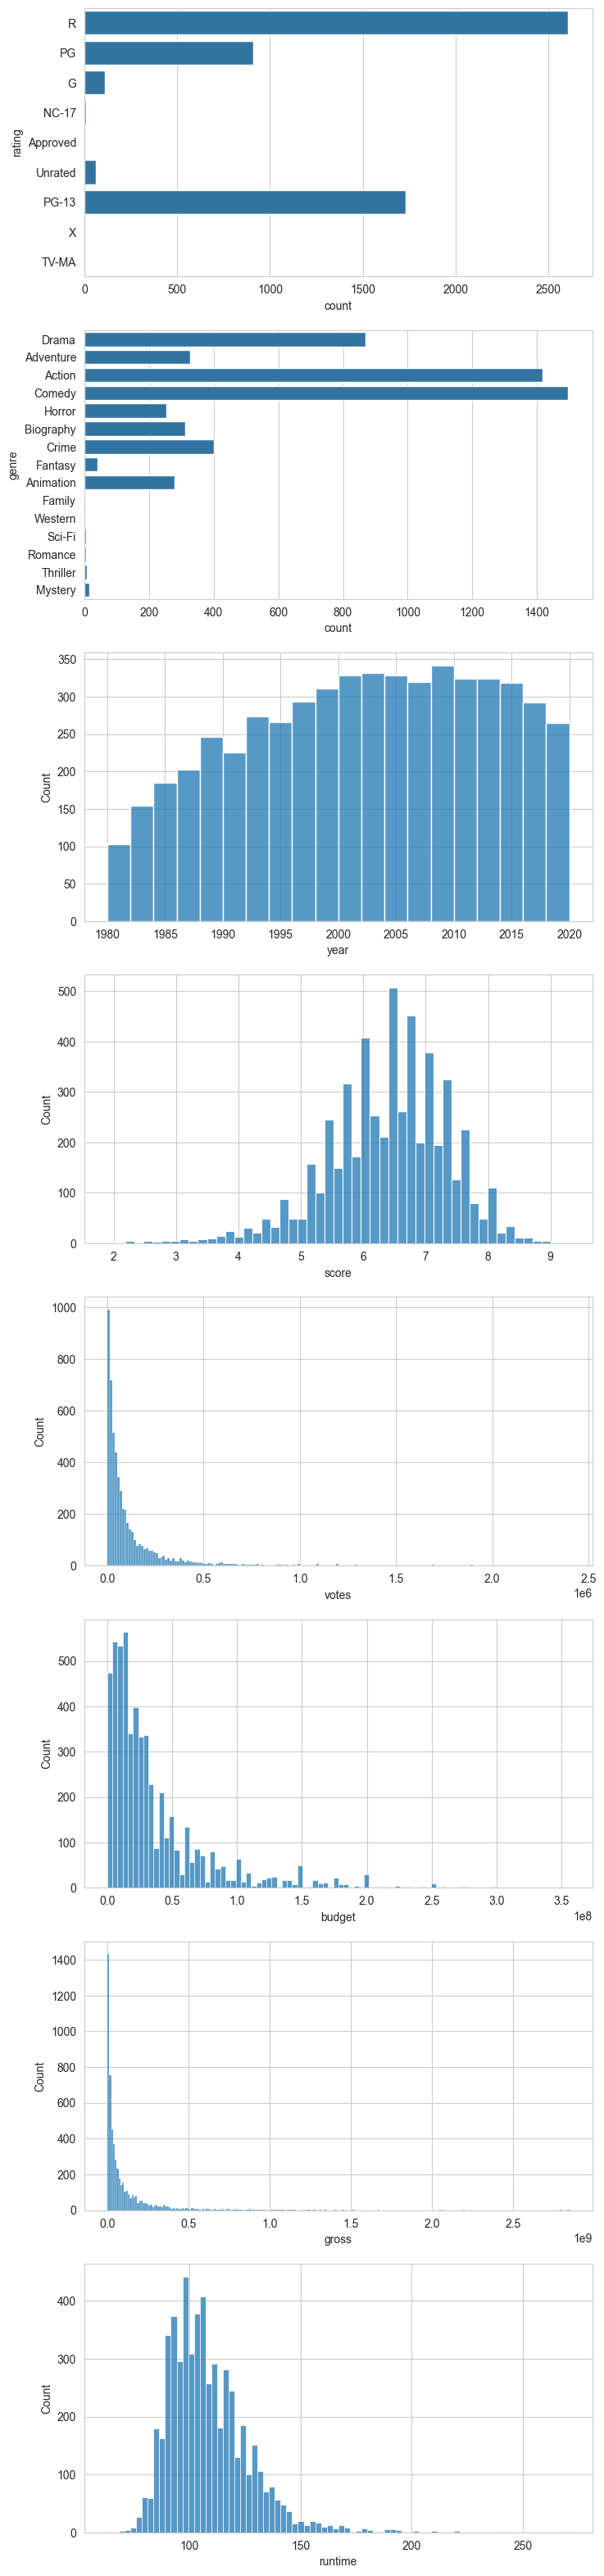

In [58]:
df = pd.read_csv('../dataset/movies_v2.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'year', 'score', 'votes', 'budget', 'gross', 'runtime']

plot_dist(df, cols_to_retain)

In [59]:
# preparazione dei dati

X_train, X_test, y_train, y_test = prepare_data(df, 'score', drop_cols=list(df.columns.difference(cols_to_retain)),
                                                dummies_cols=['genre', 'rating'], standardize_cols=['runtime'],
                                                log_standardize_cols=['budget', 'gross', 'votes'],
                                                minmax_standardize_cols=['year'])

In [60]:
# addestramento e tuning della LinearRegression

model = LinearRegression()

params = {
    'fit_intercept': [True, False]
}

best_model = tune_model(model, 'LinearRegression', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'], verbose=True)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

Results for [LinearRegression] after GridSearchCV:
Best parameters: {'fit_intercept': True}
Best score: {'neg_mean_squared_error': -0.4488150656854959}

Test score: 0.4553925809139244


Results for [DecisionTreeRegressor] after GridSearchCV:
Best parameters: {'criterion': 'squared_error', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: {'neg_mean_squared_error': -0.6592843568767419}
Results for [DecisionTreeRegressor] after max_depth tuning:
Best parameters: {'max_depth': 19}
Best score: {'neg_mean_squared_error': 0.6583923569971989}


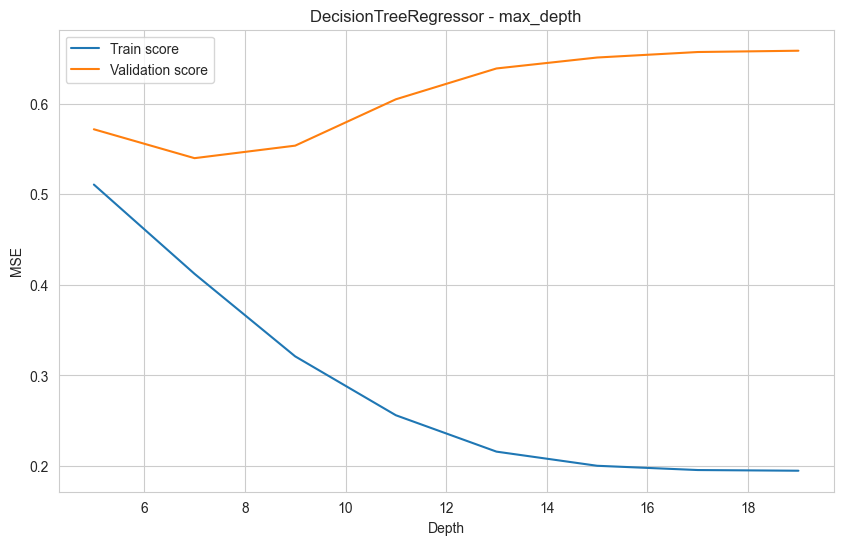


Test score: 0.6018259574576358


In [61]:
# addestramento e tuning del DecisionTreeRegressor

model = DecisionTreeRegressor() 

params = {
    'criterion': ['squared_error', 'friedman_mse'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

best_model = tune_model(model, 'DecisionTreeRegressor', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        cv_params={'max_depth': [d for d in range(5, 20, 2)]}, cv_metric='neg_mean_squared_error', verbose=True, plot=True,
                        xlabel='Depth', ylabel='MSE')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

Results for [RandomForestRegressor] after GridSearchCV:
Best parameters: {'criterion': 'squared_error', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: {'neg_mean_squared_error': -0.4219836835338969}
Results for [RandomForestRegressor] after max_depth tuning:
Best parameters: {'max_depth': 5}
Best score: {'neg_mean_squared_error': 0.49935575172291546}


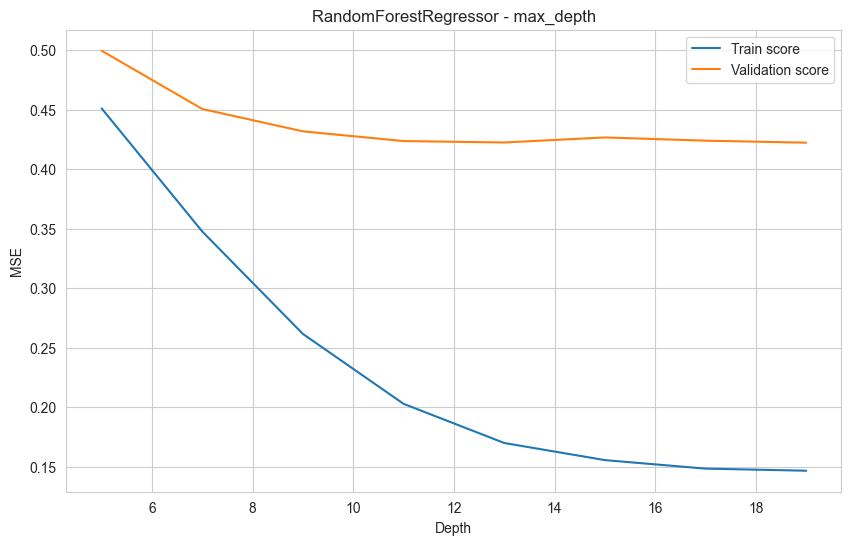

Results for [RandomForestRegressor] after n_estimators tuning:
Best parameters: {'n_estimators': 10}
Best score: {'neg_mean_squared_error': 0.4488883718161046}


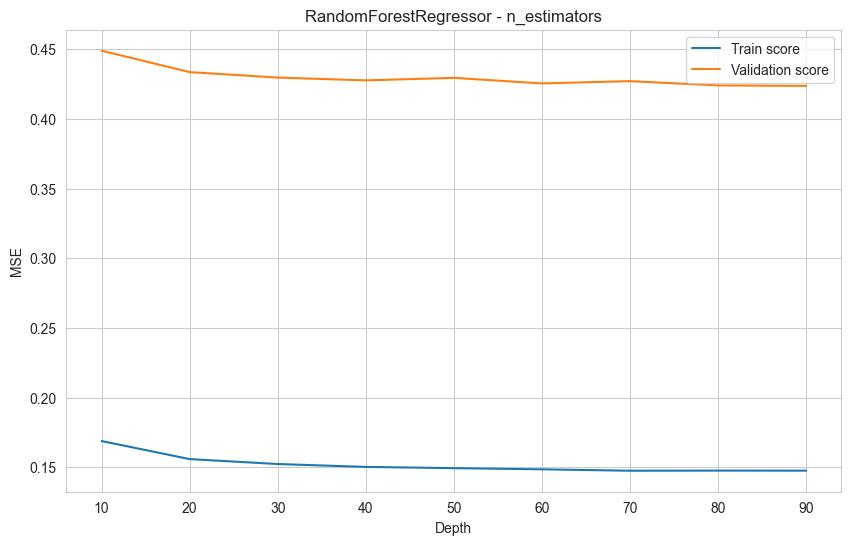


Test score: 0.39336696299631035


In [62]:
# addestramento e tuning del RandomForestRegressor

model = RandomForestRegressor() 

params = {
    'criterion': ['squared_error', 'friedman_mse'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

best_model = tune_model(model, 'RandomForestRegressor', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        cv_params={'max_depth': [d for d in range(5, 20, 2)], 
                                   'n_estimators': [d for d in range(10, 100, 10)]}, 
                        cv_metric='neg_mean_squared_error', verbose=True, plot=True,
                        xlabel='Depth', ylabel='MSE')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

C:\Users\raffa\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\raffa\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\raffa\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\raffa\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 666, in _validate_params
    vali

Results for [GradientBoostingRegressor] after GridSearchCV:
Best parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: {'neg_mean_squared_error': -0.41580626524106334}
Results for [GradientBoostingRegressor] after max_depth tuning:
Best parameters: {'max_depth': 19}
Best score: {'neg_mean_squared_error': 0.5674805791197037}


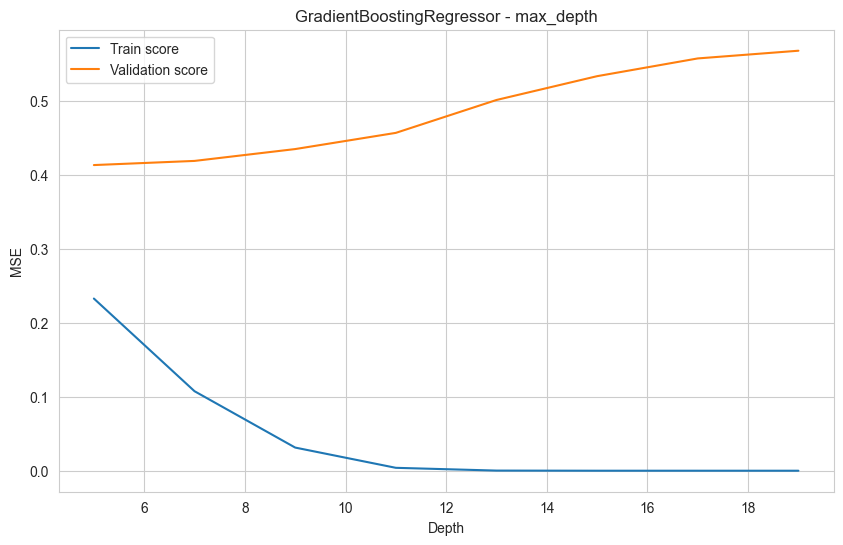

Results for [GradientBoostingRegressor] after n_estimators tuning:
Best parameters: {'n_estimators': 60}
Best score: {'neg_mean_squared_error': 0.5676937608217781}


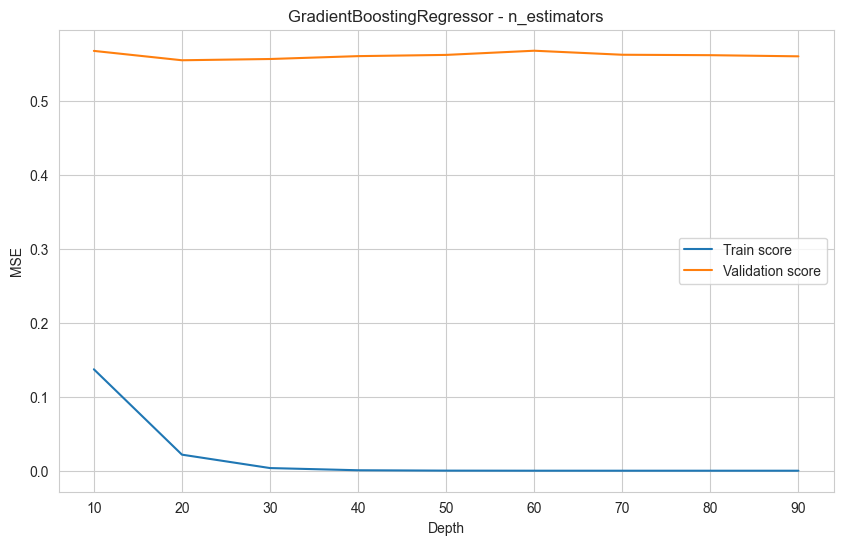


Test score: 0.5098516254742462


In [64]:
# addestramento e tuning del GradientBoostingRegressor

model = GradientBoostingRegressor()

params = {
    'loss': ['squared_error', 'friedman_mse'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.1, 0.5, 1.0]
}

best_model = tune_model(model, 'GradientBoostingRegressor', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        cv_params={'max_depth': [d for d in range(5, 20, 2)],
                                   'n_estimators': [d for d in range(10, 100, 10)]},
                        cv_metric='neg_mean_squared_error', verbose=True, plot=True,
                        xlabel='Depth', ylabel='MSE')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

In [8]:
df = pd.read_csv('../dataset/movies_final_v1.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'age', 'score', 'runtime', 'profit_index', 'success_index', 'director_num_movies', 'actor_num_movies',
                  'director_score_mean', 'director_score_std', 'actor_score_mean', 'actor_score_std',
                  'director_profit_mean', 'director_profit_std', 'actor_profit_mean', 'actor_profit_std']

In [9]:
# preparazione del dataset per l'addestramento

X_train, X_test, y_train, y_test = prepare_data(df, target_col='score', 
                                                   drop_cols=list(df.columns.difference(cols_to_retain)),
                                                   dummies_cols=['genre', 'rating'],
                                                   standardize_cols=['runtime', 'profit_index', 'success_index'],
                                                   log_standardize_cols=[],
                                                   minmax_standardize_cols=['age', 'director_num_movies', 'actor_num_movies'])

In [10]:
# addestramento e tuning della LinearRegression

model = LinearRegression()

params = {
    'fit_intercept': [True, False]
}

best_model = tune_model(model, 'LinearRegression', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        verbose=True)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

Results for [LinearRegression] after GridSearchCV:
Best parameters: {'fit_intercept': True}
Best score: {'neg_mean_squared_error': -2.785778398955011}

Test score: 0.4079668252549563


Results for [DecisionTreeRegressor] after GridSearchCV:
Best parameters: {'criterion': 'squared_error', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: {'neg_mean_squared_error': -0.32613026279960644}
Results for [DecisionTreeRegressor] after max_depth tuning:
Best parameters: {'max_depth': 19}
Best score: {'neg_mean_squared_error': 0.32674872003322464}


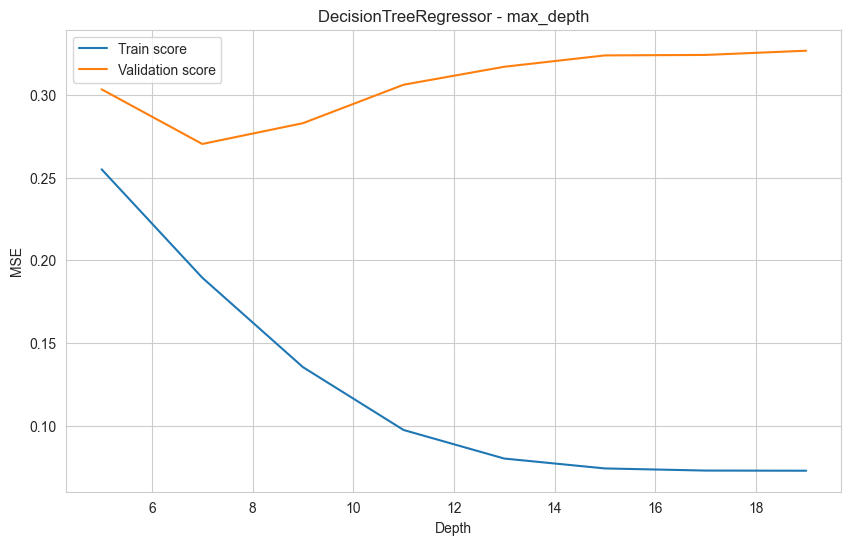


Test score: 0.30863254985705174


In [11]:
# addestramento e tuning del DecisionTreeRegressor

model = DecisionTreeRegressor()

params = {
    'criterion': ['squared_error', 'friedman_mse'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

best_model = tune_model(model, 'DecisionTreeRegressor', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        cv_params={'max_depth': [d for d in range(5, 20, 2)]}, cv_metric='neg_mean_squared_error', verbose=True, plot=True,
                        xlabel='Depth', ylabel='MSE')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

Results for [RandomForestRegressor] after GridSearchCV:
Best parameters: {'criterion': 'friedman_mse', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: {'neg_mean_squared_error': -0.20021878561069348}
Results for [RandomForestRegressor] after max_depth tuning:
Best parameters: {'max_depth': 5}
Best score: {'neg_mean_squared_error': 0.25058871689631024}


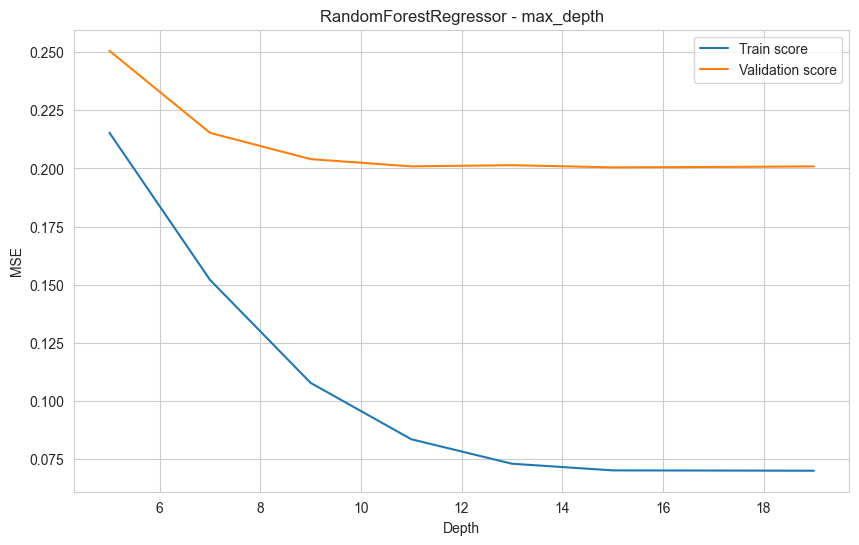

Results for [RandomForestRegressor] after n_estimators tuning:
Best parameters: {'n_estimators': 10}
Best score: {'neg_mean_squared_error': 0.21334493454659262}


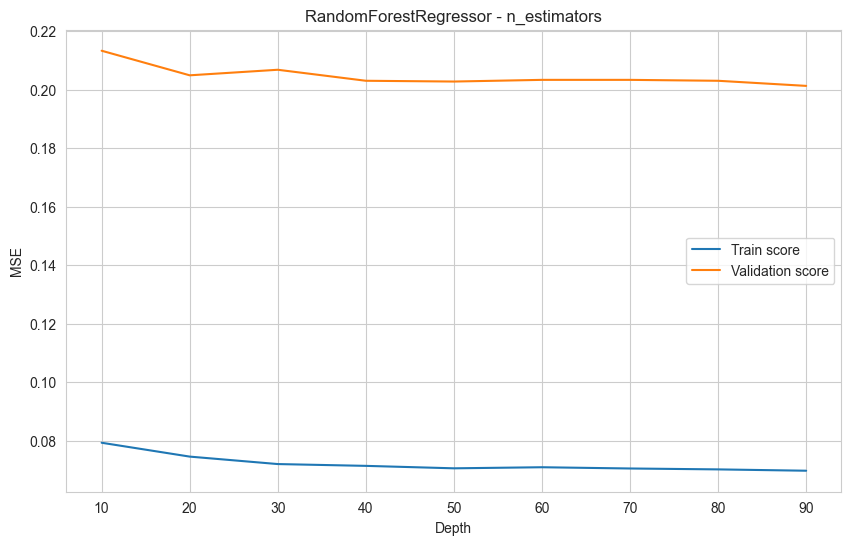


Test score: 0.19076639198413503


In [12]:
# addestramento e tuning del RandomForestRegressor

model = RandomForestRegressor()

params = {
    'criterion': ['squared_error', 'friedman_mse'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

best_model = tune_model(model, 'RandomForestRegressor', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        cv_params={'max_depth': [d for d in range(5, 20, 2)], 
                                   'n_estimators': [d for d in range(10, 100, 10)]}, 
                        cv_metric='neg_mean_squared_error', verbose=True, plot=True,
                        xlabel='Depth', ylabel='MSE')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')

Results for [GradientBoostingRegressor] after GridSearchCV:
Best parameters: {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best score: {'neg_mean_squared_error': -0.20358862262734617}
Results for [GradientBoostingRegressor] after max_depth tuning:
Best parameters: {'max_depth': 19}
Best score: {'neg_mean_squared_error': 0.22760377146313338}


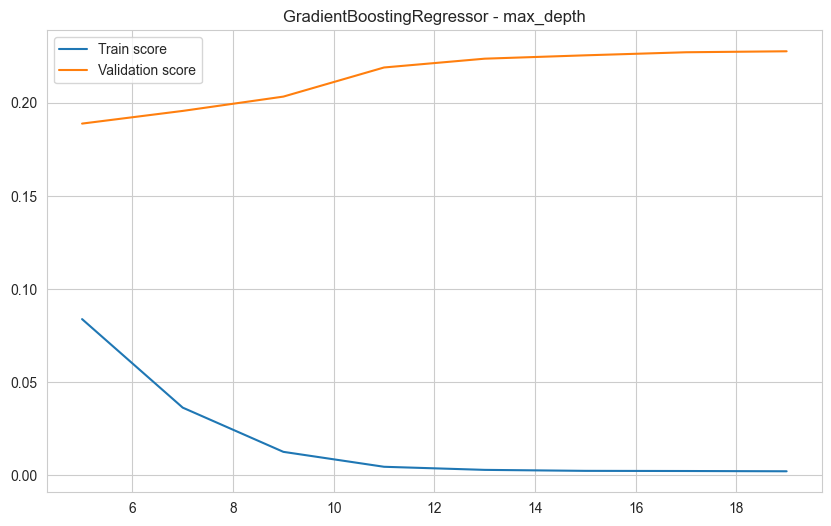

Results for [GradientBoostingRegressor] after n_estimators tuning:
Best parameters: {'n_estimators': 10}
Best score: {'neg_mean_squared_error': 0.32640855833450316}


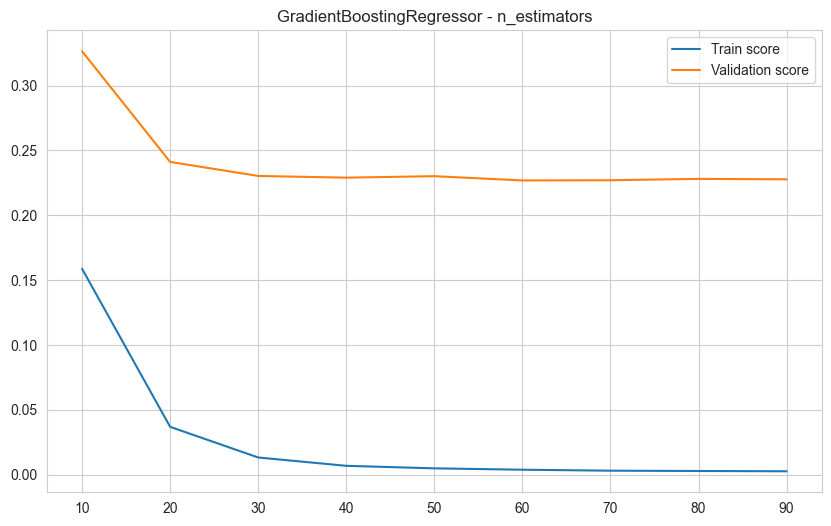


Test score: 0.20683788799711464


In [13]:
# addestramento e tuning del GradientBoostingRegressor

model = GradientBoostingRegressor()

params = {
    'loss': ['squared_error', 'huber'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.1, 0.5, 1.0]
}

best_model = tune_model(model, 'GradientBoostingRegressor', X_train, y_train, cv=5,
                        grid_params=params, grid_metrics=['neg_mean_squared_error'],
                        cv_params={'max_depth': [d for d in range(5, 20, 2)],
                                   'n_estimators': [d for d in range(10, 100, 10)]},
                        cv_metric='neg_mean_squared_error', plot=True,
                        verbose=True)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'\nTest score: {mean_squared_error(y_test, y_pred)}')